# RoC Analysis SVM

## Data Generation
* Fix a beta* value and number of predictors
* Create a Y vector using Bernoulli distribution for logit
* Create a X vector using normal distribution as i.i.ds

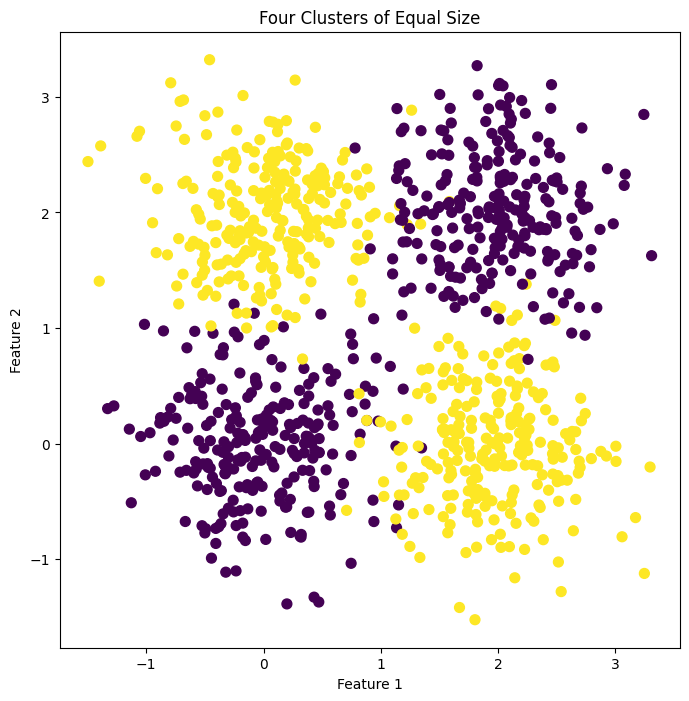

Training data shape: (800, 2), (800,)
Test data shape: (200, 2), (200,)


In [11]:
no_predictors = 2
no_samples = 1000
no_classes = 2

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

n_samples_per_cluster = 250
n_clusters = 4

# Create the clusters deterministically
np.random.seed(0) # for reproducibility

X = np.zeros((n_samples_per_cluster * n_clusters, 2))
y = np.zeros(n_samples_per_cluster * n_clusters)

# Cluster centers in corners of a square
centers = [[0, 0], [2, 0], [0, 2], [2, 2]]

# Assign points to clusters deterministically
for i in range(n_clusters):
    cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
    X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
    if i == 0 or i == 3:
        y[cluster_indices] = 0
    else:
        y[cluster_indices] = 1



#Visualize
plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
plt.title('Four Clusters of Equal Size')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

#add intercept to X
#X = np.hstack((np.ones((X.shape[0], 1)), X))

# # shuffle data
# permutation = np.random.permutation(no_samples)
# X = X[permutation]
# y = y[permutation]


#Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")





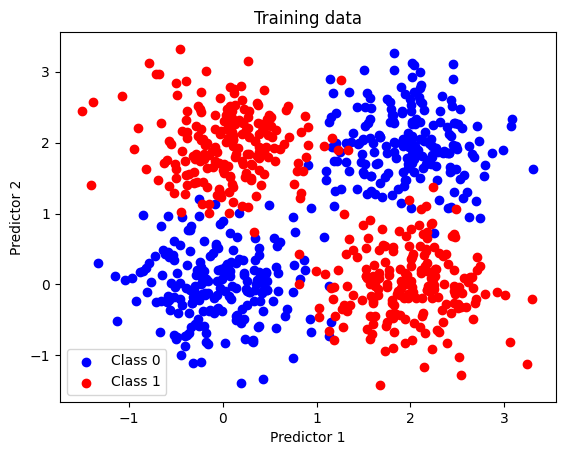

In [12]:
plt.figure()
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], color='b', label='Class 0') 
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='r', label='Class 1') 
plt.xlabel('Predictor 1') 
plt.ylabel('Predictor 2') 
plt.legend()
plt.title('Training data')
plt.show()

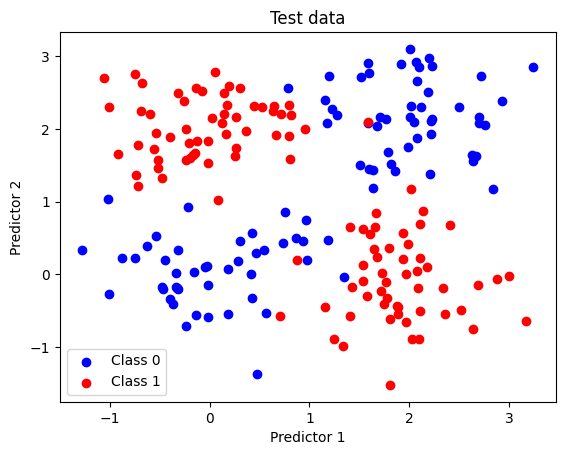

In [13]:
plt.figure()
plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], color='b', label='Class 0') 
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color='r', label='Class 1') 
plt.xlabel('Predictor 1') 
plt.ylabel('Predictor 2') 
plt.legend()
plt.title('Test data')
plt.show()

## SVM based Support vector classifier

In [19]:
# Support Vector Machine
from sklearn.svm import SVC
clf = SVC(kernel='poly', probability=True, degree=2)
clf.fit(X_train, y_train)
#beta_hat = clf.coef_[0] # w parameter in SVM
#intercept = clf.intercept_[0] # b parameter in SVM

# print('True beta: ', beta_star)
#print('Estimated beta: ', beta_hat)
#print('Intercept: ', intercept)
# print('Mean squared error: ', np.mean((beta_star - beta_hat) ** 2))

SVC(degree=2, kernel='poly', probability=True)

## Standard RoC curve

Length of threshold prc 194
Length of threshold_roc 40


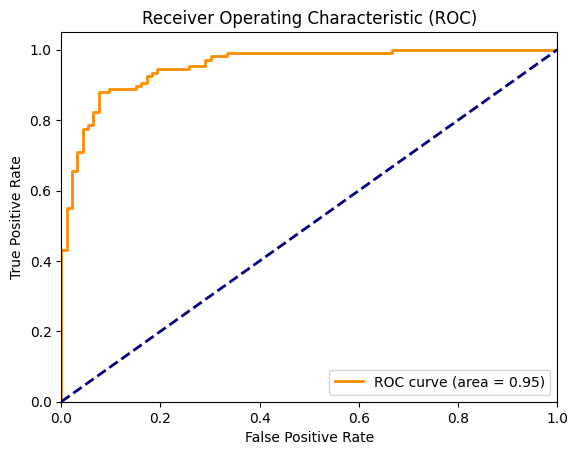

In [20]:
# Plot the RoC curve
from sklearn.metrics import roc_curve, precision_recall_curve, auc
fpr_roc, tpr_roc, threshold_roc = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
precision_prc, recall_prc, threshold_prc = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])

print("Length of threshold prc", len(threshold_prc))
print("Length of threshold_roc", len(threshold_roc))

roc_auc = auc(fpr_roc, tpr_roc)

# Plot the ROC curve
plt.figure()
plt.plot(fpr_roc, tpr_roc, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line representing random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


## RoC curve by cost-sensitive learning

The following function fixes the threshold value. The input model to the function will be weighted in order to have the bias towards the minority class

In [16]:
import numpy as np
from sklearn.metrics import confusion_matrix

def get_fpr_tpr(clf_model, X_test, y_test, threshold=0.5):
    """
    Calculates the False Positive Rate (FPR) and True Positive Rate (TPR) at a given threshold.

    Args:
        X_test: The test features.
        y_test: The true test labels (0 or 1).
        threshold: The probability threshold.

    Returns:
        A dictionary containing the FPR and TPR. Returns None if there's an error.
    """
    try:
        y_pred = clf_model.predict(X_test) # predict directly

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  #Avoid division by zero
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0 #Avoid division by zero
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        misclassification_rate = 1 - accuracy

        return {"fpr": fpr, "tpr": tpr, "precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy, "misclassification_rate": misclassification_rate}

    except ValueError as e:
        print(f"Error calculating FPR and TPR: {e}")
        return None





In [11]:
# Test the function
threshold = 0.5
result = get_fpr_tpr(clf, X_test, y_test, threshold=threshold)
print(f"FPR: {result['fpr']:.3f}, TPR: {result['tpr']:.3f}, precision: {result['precision']}, recall {result['recall']}, f1 {result['f1']} at threshold {threshold}")

threshold = 0.7
result = get_fpr_tpr(clf, X_test, y_test, threshold=threshold)
print(f"FPR: {result['fpr']:.3f}, TPR: {result['tpr']:.3f}, precision: {result['precision']}, recall {result['recall']}, f1 {result['f1']} at threshold {threshold}")

FPR: 0.000, TPR: 1.000, precision: 1.0, recall 1.0, f1 1.0 at threshold 0.5
FPR: 0.000, TPR: 1.000, precision: 1.0, recall 1.0, f1 1.0 at threshold 0.7


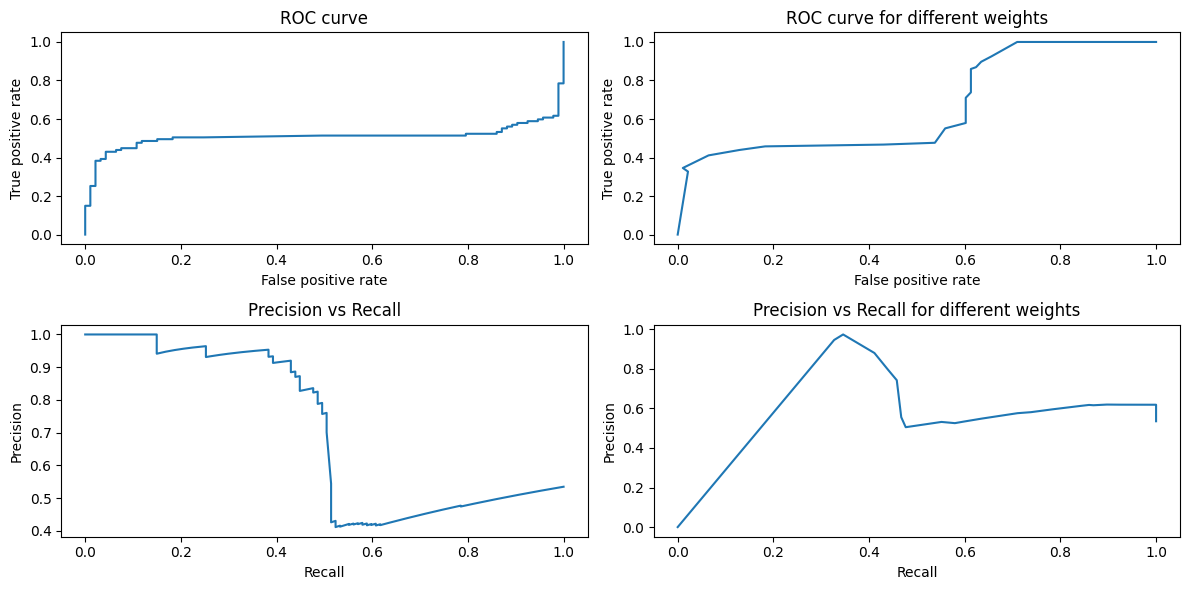

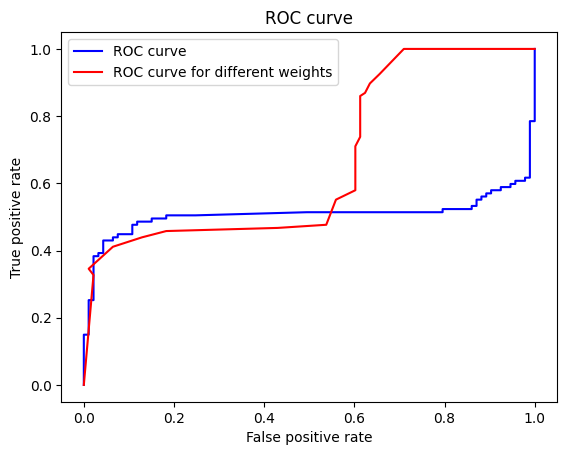

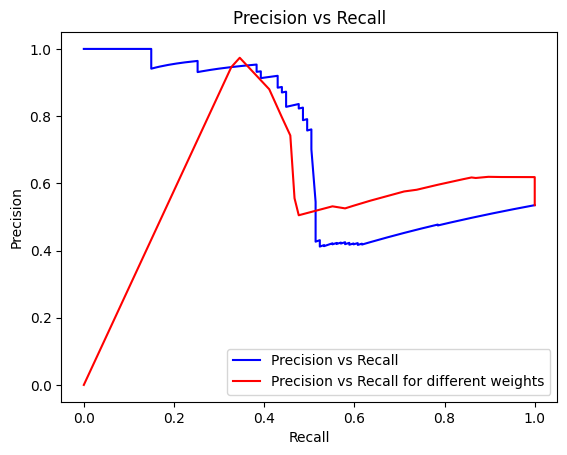

In [ ]:
# Weight the X_train and y_train for cost-sensitive learning
minority_class_weight = np.arange(0.001, 0.999, 0.001)
majority_class_weight = 1.0 - minority_class_weight
dict_weighted_clfs = {}
for w in minority_class_weight:
    class_weights = {0: 1 - w, 1: w}

    clf_weighted = SVC(kernel='poly', probability=True, class_weight=class_weights, degree=2)
    clf_weighted.fit(X_train, y_train)

    res = get_fpr_tpr(clf_weighted, X_test, y_test, threshold=0.5)
    dict_weighted_clfs[w] = {
        "model": clf_weighted,
        "fpr": res["fpr"],
        "tpr": res["tpr"],
        "precision": res["precision"],
        "recall": res["recall"],
        "f1": res["f1"],
        "accuracy": res["accuracy"],
        "misclassification_rate": res["misclassification_rate"]
    }
    #print(f"Weight: {w:.2f}, FPR: {res['fpr']:.3f}, TPR: {res['tpr']:.3f}")

# Plot the FPR vs TPR for the different weights
fig,ax = plt.subplots(2, 2, figsize=(12, 6))
ax[0][0].plot(fpr_roc, tpr_roc)
ax[0][0].set_xlabel('False positive rate')
ax[0][0].set_ylabel('True positive rate')
ax[0][0].set_title('ROC curve')
ax[0][1].plot([v["fpr"] for v in dict_weighted_clfs.values()], [v["tpr"] for v in dict_weighted_clfs.values()])
ax[0][1].set_xlabel('False positive rate')
ax[0][1].set_ylabel('True positive rate')
ax[0][1].set_title('ROC curve for different weights')
ax[1][0].plot(recall_prc, precision_prc)
ax[1][0].set_xlabel('Recall')
ax[1][0].set_ylabel('Precision')
ax[1][0].set_title('Precision vs Recall')
ax[1][1].plot([v["recall"] for v in dict_weighted_clfs.values()], [v["precision"] for v in dict_weighted_clfs.values()])
ax[1][1].set_xlabel('Recall')
ax[1][1].set_ylabel('Precision')
ax[1][1].set_title('Precision vs Recall for different weights')


plt.tight_layout()
plt.show()

# Plot both the curves on the same plot figure
plt.figure()
figsize=(12, 12)
plt.plot(fpr_roc, tpr_roc, label='ROC curve',color='blue')
plt.plot([v["fpr"] for v in dict_weighted_clfs.values()], [v["tpr"] for v in dict_weighted_clfs.values()], label='ROC curve for different weights',color='red')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('ROC curve')
plt.show()

plt.figure()
figsize=(12, 12)
plt.plot(recall_prc, precision_prc, label='Precision vs Recall',color='blue')
plt.plot([v["recall"] for v in dict_weighted_clfs.values()], [v["precision"] for v in dict_weighted_clfs.values()], label='Precision vs Recall for different weights',color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision vs Recall')
plt.show()


### Analysis of the beta values

The current belief is that the $\beta_0$ values should remain constant for both the RoC curve estimates. Now we will plot the log-odds graph of the different estimates.

/tmp/ipykernel_78138/1482532912.py:24: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/tmp/ipykernel_78138/1482532912.py:24: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/tmp/ipykernel_78138/1482532912.py:25: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  path = contour.collections[0].get_paths()[0]
/tmp/ipykernel_78138/1482532912.py:24: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/tmp/ipykernel_78138/1482532912.py:25: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 an

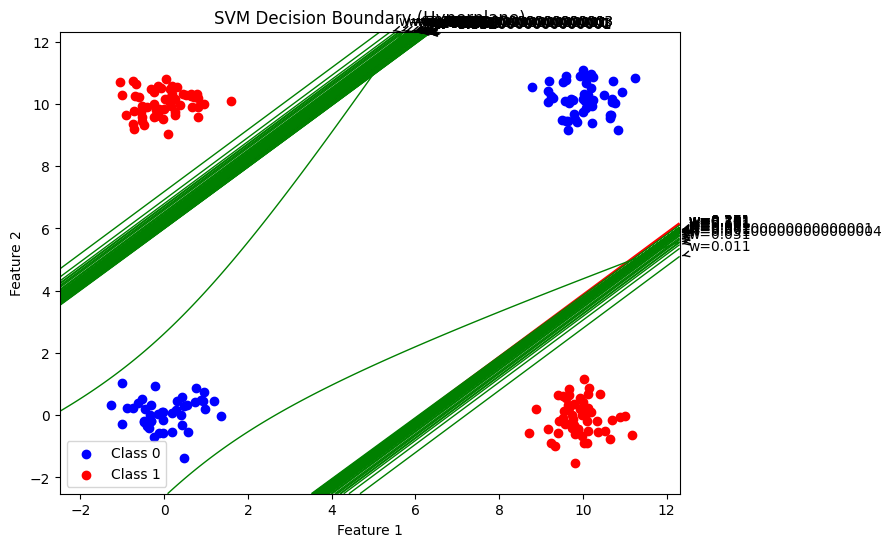

In [39]:
# Create meshgrid
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

# Get decision function values
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary (hyperplane)
plt.figure(figsize=(8, 6))
#plt.contourf(xx, yy, Z, alpha=0.8, cmap='RdBu')  # Fill the regions
plt.contour(xx, yy, Z, levels=[0], colors=['r'], linewidths=2)  # Hyperplane

for index in range(0, len(minority_class_weight), 10):
    w = minority_class_weight[index]
    Z = dict_weighted_clfs[w]["model"].decision_function(
                np.c_[xx.ravel(), yy.ravel()]
            )
    Z = Z.reshape(xx.shape)
    contour = plt.contour(xx, yy, Z, levels=[0], colors=["g"], linewidths=1)  # Hyperplane
    # Annotate the line with the 'w' value
    # Find a suitable position for the annotation
    if contour.collections and contour.collections[0].get_paths():
        path = contour.collections[0].get_paths()[0]
        vertices = path.vertices
        center = vertices[len(vertices) // 2]
        plt.annotate(
            f"w={w}",
            xy=center,
            xytext=(center[0]+0.2, center[1]+0.2),
            textcoords="data",
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3")
        )
    else:
        #do nothing
        pass
        #print(f"Warning: No contour line found at level 0 for w={w}. Skipping annotation.")


# Plot data points
plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], color='b', label='Class 0') 
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color='r', label='Class 1') 

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('SVM Decision Boundary (Hyperplane)')
plt.legend()
plt.show()

## Plot the decision boundaries

### Plot the misclassification rate for all the different thresholds

## Conclusion

* 1. For the simple logistic regression function, the RoC curve either generated by changing the threshold or by changing the weights generate similar results.
* 2. Changing weights take longer to execute